<a href="https://colab.research.google.com/github/SergeyShchus/Automatic_GIS/blob/master/Notebook/Geopandas/Spatial_index_with_Geopandas.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%%time 

# Important library for many geopython libraries
!apt install gdal-bin python-gdal python3-gdal 
# Install rtree - Geopandas requirment
!apt install python3-rtree 
# Install Geopandas
!pip install git+git://github.com/geopandas/geopandas.git
# Install descartes - Geopandas requirment
!pip install descartes 
# Install Folium for Geographic data visualization
!pip install folium
# Install plotlyExpress
!pip install plotly_express

import pandas as pd
import geopandas as gpd
from shapely.geometry import Point

from google.colab import drive
drive.mount('/content/gdrive')

Reading package lists... Done
Building dependency tree       
Reading state information... Done
gdal-bin is already the newest version (2.2.3+dfsg-2).
python-gdal is already the newest version (2.2.3+dfsg-2).
The following additional packages will be installed:
  python3-numpy
Suggested packages:
  python-numpy-doc python3-nose python3-numpy-dbg
The following NEW packages will be installed:
  python3-gdal python3-numpy
0 upgraded, 2 newly installed, 0 to remove and 13 not upgraded.
Need to get 2,288 kB of archives.
After this operation, 13.2 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/main amd64 python3-numpy amd64 1:1.13.3-2ubuntu1 [1,943 kB]
Get:2 http://archive.ubuntu.com/ubuntu bionic/universe amd64 python3-gdal amd64 2.2.3+dfsg-2 [346 kB]
Fetched 2,288 kB in 1s (2,471 kB/s)
Selecting previously unselected package python3-numpy.
(Reading database ... 149406 files and directories currently installed.)
Preparing to unpack .../python3-numpy_

In [2]:

# Filepaths
intersections_fp = "/content/uusimaa_intersections.gpkg"
postcode_areas_fp = "/content/uusimaa_postal_code_areas.gpkg"

intersections = gpd.read_file(intersections_fp)
postcode_areas = gpd.read_file(postcode_areas_fp)

# Let's check first rows
print(intersections.head(), '\n-------')
print(postcode_areas.head())

/usr/local/lib/python3.7/dist-packages/geopandas/geodataframe.py:565: RuntimeWarning: Sequential read of iterator was interrupted. Resetting iterator. This can negatively impact the performance.
  for feature in features_lst:


            x            y                        geometry
0  330888.502  6675829.949  POINT (330888.502 6675829.949)
1  348059.990  6670041.685  POINT (348059.990 6670041.685)
2  348022.592  6670202.858  POINT (348022.592 6670202.858)
3  297208.220  6669048.357  POINT (297208.220 6669048.357)
4  330835.341  6675586.834  POINT (330835.341 6675586.834) 
-------
  posti_alue  he_vakiy                                           geometry
0      00100   18284.0  MULTIPOLYGON (((385653.893 6671591.048, 385573...
1      00120    7108.0  MULTIPOLYGON (((385316.092 6671076.984, 385279...
2      00130    1508.0  MULTIPOLYGON (((386212.111 6671061.262, 386176...
3      00140    7865.0  MULTIPOLYGON (((386577.050 6670280.544, 386552...
4      00150    9496.0  MULTIPOLYGON (((384846.102 6669565.816, 384823...


In [3]:
print("Number of intersections:", len(intersections))
print("Number of postal code areas:", len(postcode_areas))

Number of intersections: 63518
Number of postal code areas: 370


(6667500.0, 6680000.0)

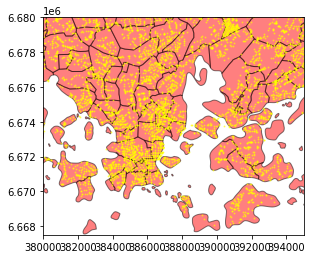

In [4]:
%matplotlib inline
ax = postcode_areas.plot(color='red', edgecolor='black', alpha=0.5)
ax = intersections.plot(ax=ax, color='yellow', markersize=1, alpha=0.5)

# Zoom to closer (comment out the following to see the full extent of the data)
ax.set_xlim([380000, 395000])
ax.set_ylim([6667500, 6680000])

In [5]:
# Let's build spatial index for intersection points
intersection_sindex = intersections.sindex

# Let's see what it is
intersection_sindex

In [8]:
# How many groups do we have?
print("Number of groups:", len(intersection_sindex.leaves()), '\n')

# Print some basic info for few of them
n_iterations = 10
for i, group in enumerate(intersection_sindex.leaves()):
    group_idx, indices, bbox = group
    print("Group", group_idx, "contains ", len(indices), "geometries, bounding box:", bbox)
    i+=1
    if i == n_iterations:
        break

Number of groups: 908 

Group 0 contains  70 geometries, bounding box: [270305.195, 6632767.892, 279497.993, 6638674.424]
Group 2 contains  70 geometries, bounding box: [272155.57, 6638680.047, 285753.31, 6638976.355]
Group 3 contains  70 geometries, bounding box: [271904.727, 6638983.54, 286463.059, 6639181.123]
Group 4 contains  70 geometries, bounding box: [271790.007, 6639184.018, 284495.801, 6639351.784]
Group 5 contains  70 geometries, bounding box: [271952.787, 6639354.724, 284589.912, 6639564.576]
Group 6 contains  70 geometries, bounding box: [271784.854, 6639571.546, 285241.406, 6639760.222]
Group 7 contains  70 geometries, bounding box: [271813.417, 6639762.182, 285147.276, 6639945.834]
Group 8 contains  70 geometries, bounding box: [271646.281, 6639949.717, 283451.674, 6640149.228]
Group 9 contains  70 geometries, bounding box: [272335.073, 6640150.564, 282567.285, 6640318.718]
Group 10 contains  70 geometries, bounding box: [272318.947, 6640321.762, 286352.142, 6641062.815

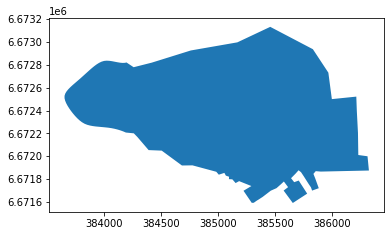

In [9]:
# Select a postal code area representing the city center of Helsinki
city_center_zip_area = postcode_areas.loc[postcode_areas['posti_alue']=='00100']
city_center_zip_area.plot()

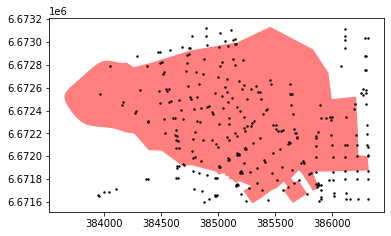

In [10]:
# Get the bounding box coordinates of the Polygon as a list
bounds = list(city_center_zip_area.bounds.values[0])

# Get the indices of the Points that are likely to be inside the bounding box of the given Polygon
point_candidate_idx = list(intersection_sindex.intersection(bounds))
point_candidates = intersections.loc[point_candidate_idx]

# Let's see what we have now
ax = city_center_zip_area.plot(color='red', alpha=0.5)
ax = point_candidates.plot(ax=ax, color='black', markersize=2)

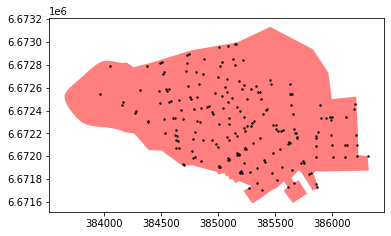

In [11]:
# Make the precise Point in Polygon query
final_selection = point_candidates.loc[point_candidates.intersects(city_center_zip_area['geometry'].values[0])]

# Let's see what we have now
ax = city_center_zip_area.plot(color='red', alpha=0.5)
ax = final_selection.plot(ax=ax, color='black', markersize=2)

In [12]:
def intersect_using_spatial_index(source_gdf, intersecting_gdf):
    """
    Conduct spatial intersection using spatial index for candidates GeoDataFrame to make queries faster.
    Note, with this function, you can have multiple Polygons in the 'intersecting_gdf' and it will return all the points 
    intersect with ANY of those geometries.
    """
    source_sindex = source_gdf.sindex
    possible_matches_index = []
    
    # 'itertuples()' function is a faster version of 'iterrows()'
    for other in intersecting_gdf.itertuples():
        bounds = other.geometry.bounds
        c = list(source_sindex.intersection(bounds))
        possible_matches_index += c
    
    # Get unique candidates
    unique_candidate_matches = list(set(possible_matches_index))
    possible_matches = source_gdf.iloc[unique_candidate_matches]

    # Conduct the actual intersect
    result = possible_matches.loc[possible_matches.intersects(intersecting_gdf.unary_union)]
    return result

def normal_intersect(source_gdf, intersecting_gdf):
    """
    Conduct spatial intersection without spatial index.
    Note, with this function, you can have multiple Polygons in the 'intersecting_gdf' and it will return all the points 
    intersect with ANY of those geometries.
    """
    
    matches = []
    
    # 'itertuples()' function is a faster version of 'iterrows()'
    for other in intersecting_gdf.itertuples():
        c = list(source_gdf.loc[source_gdf.intersects(other.geometry)].index)
        matches += c
    
    # Get all points that are intersecting with the Polygons
    unique_matches = list(set(matches))
    result = source_gdf.loc[source_gdf.index.isin(unique_matches)]
    return result

In [14]:
# Test the spatial query with spatial index
%timeit intersect_using_spatial_index(source_gdf=intersections, intersecting_gdf=city_center_zip_area)

100 loops, best of 5: 10 ms per loop


In [15]:
# Test the spatial query without spatial index
%timeit normal_intersect(source_gdf=intersections, intersecting_gdf=city_center_zip_area)

1 loop, best of 5: 193 ms per loop


In [16]:
# Count intersections by postal code area
intersection_cnt = gpd.sjoin(postcode_areas, intersections).groupby('posti_alue').size().reset_index()
intersection_cnt.head()

,posti_alue,0
0,00100,203
1,00120,35
2,00130,50
3,00140,44
4,00150,68


In [17]:
# Merge with postcode data and plot
intersection_cnt = intersection_cnt.rename(columns={0: 'intersection_cnt'})
postcode_areas = postcode_areas.merge(intersection_cnt, on='posti_alue')
postcode_areas

,posti_alue,he_vakiy,geometry,intersection_cnt
0,00100,18284.0,"MULTIPOLYGON (((385653.893 6671591.048, 385573...",203
1,00120,7108.0,"MULTIPOLYGON (((385316.092 6671076.984, 385279...",35
2,00130,1508.0,"MULTIPOLYGON (((386212.111 6671061.262, 386176...",50
3,00140,7865.0,"MULTIPOLYGON (((386577.050 6670280.544, 386552...",44
4,00150,9496.0,"MULTIPOLYGON (((384846.102 6669565.816, 384823...",68
...,...,...,...,...
338,25470,279.0,"MULTIPOLYGON (((305067.212 6673543.615, 304620...",16
339,25500,3391.0,"MULTIPOLYGON (((277988.374 6665076.564, 277959...",86
340,25560,208.0,"MULTIPOLYGON (((294139.092 6671931.426, 291442...",48
341,31350,235.0,"MULTIPOLYGON (((329443.822 6726297.286, 329125...",2


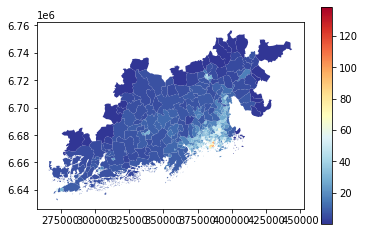

In [18]:
# Plot intersection density (number of intersections per square kilometer inside a Postal code)
m2_to_km2_converter = 1000000
postcode_areas['intersection_density'] = postcode_areas['intersection_cnt'] / (postcode_areas.area / m2_to_km2_converter)
postcode_areas.plot('intersection_density', cmap='RdYlBu_r', legend=True)